# Entwicklungstätigkeit und Code Reviews

Diese Analyse beschäftigt sich mit der Bedeutung von Code Reviews in Bezug auf die Expertise der Entwickler:innen und der Beschäftigung mit neuen Technologien. Dabei wird das Auftreten von Code Reviews und Entwicklungen nach Entwickler:in und Technologie dargestellt.

## Laden relevanter Daten aus der Datenbank

Als erster Schritt werden die für die Analyse relevanten Daten aus der Datenbank geladen. Dazu werden für jede/n Entwickler:in die Commits und Code Reviews nach Technologie sowie deren zeitliches Auftreten für die Analyse vorbereitet.

In [1]:
import shared.paths as paths
import shared.locals as locals
from tinydb.queries import where
from datetime import datetime
from helpers.config import Configuration
from database.database import Database
from database.models import Commit, Merge, Project, User

database = Database(paths.DATABASE_PATH, cached=True)
config = Configuration.from_input_file(paths.CONFIG_PATH)

technologies = config.technologies
users = database.all(User.LABEL)

results = {}
dates = set()

for user in users:

    user_result = {
        "commits": {technology: [] for technology in technologies},
        "reviews": {technology: [] for technology in technologies}
    }
    commits = database.query(Commit.LABEL, where("author_id") == user.id)
    
    for commit in commits:
        project_technologies = database.query(Project.LABEL, 
            where("id") == commit.project_id)[0].technologies
        
        dt = datetime.utcfromtimestamp(commit.timestamp)
        for technology in project_technologies:
            user_result["commits"][technology].append(dt)
        dates.add(dt.date())
    
    for merge in database.query(Merge.LABEL, 
        where("contributor_ids").any(user.id)):
        
        project_technologies = database.query(Project.LABEL, 
            where("id") == merge.project_id)[0].technologies

        dt = datetime.utcfromtimestamp(merge.timestamp)
        for technology in project_technologies:
            user_result["reviews"][technology].append(dt)
    
    results[user.id] = user_result
years = {date.year for date in dates}

## Visualisierung der Daten

Im zweiten Schritt werden die Daten für die einzelnen Entwickler:innen separat dargestellt.

Entwickler:in 1

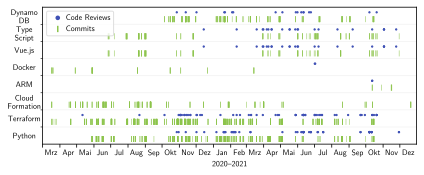

Entwickler:in 2

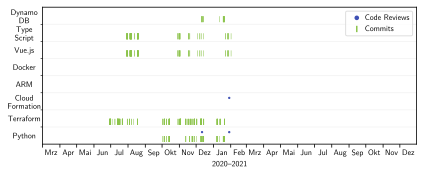

Entwickler:in 3

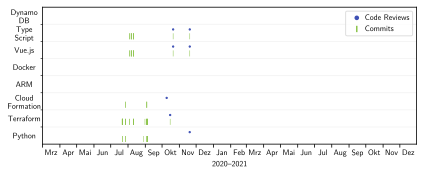

Entwickler:in 4

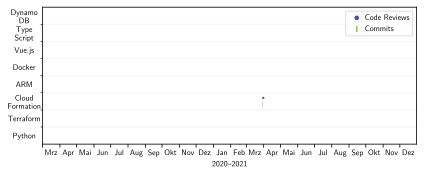

Entwickler:in 5

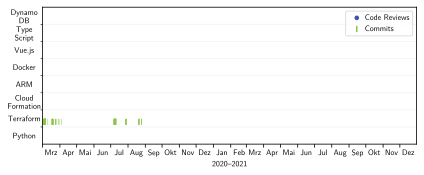

Entwickler:in 6

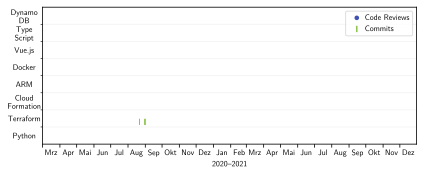

Entwickler:in 7

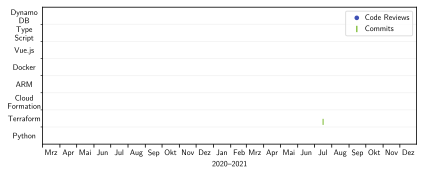

Entwickler:in 8

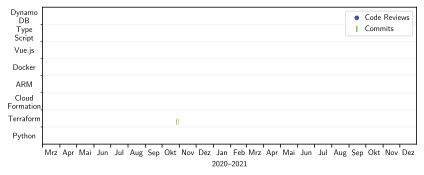

Entwickler:in 9

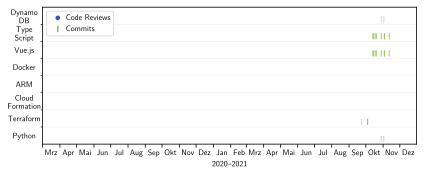

Entwickler:in 10

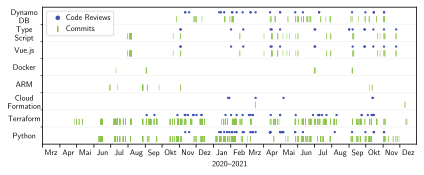

Entwickler:in 11

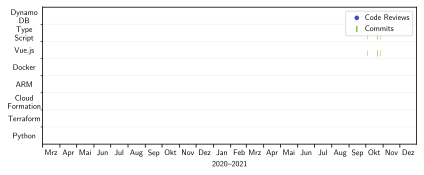

Entwickler:in 12

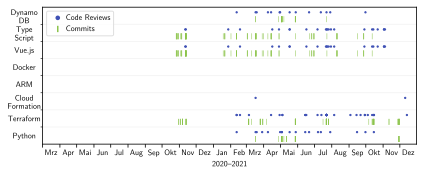

Entwickler:in 13

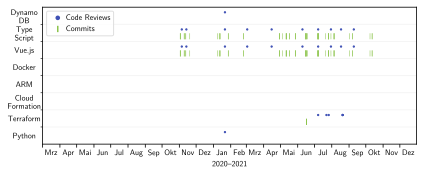

Entwickler:in 14

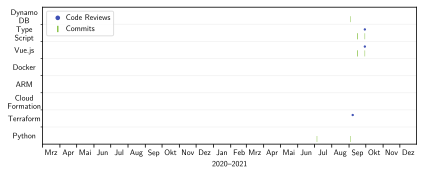

Entwickler:in 15

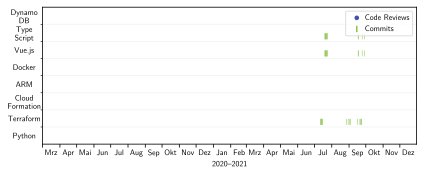

Entwickler:in 16

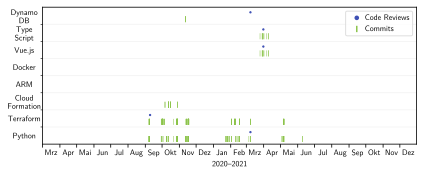

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from IPython.display import display, HTML, Markdown

plt.rc("font", **locals.FONT)

lane_assignment = {technology: index+1 for index, technology in enumerate(technologies)}

for user, result in results.items():
    fig, ax = plt.subplots(figsize=(locals.TEXTWIDTH, 2.5))
    
    review_dates = []
    review_lanes = []

    for technology in result["reviews"].keys():
        merge_result = result["reviews"][technology]
        review_dates.extend(merge_result)
        review_lanes.extend([lane_assignment[technology] + 0.2] * len(merge_result))

    ax.scatter(review_dates, review_lanes, color=locals.MATERIAL_COLORS["indigo"], label="Code Reviews",
        marker=".", s=8)

    label = "Commits"
    for technology in result["commits"].keys():
        dts = result["commits"][technology]
        lane = [lane_assignment[technology] - 0.2] * len(dts)
        ax.scatter(dts, lane, color=locals.MATERIAL_COLORS["lightgreen"], label=label,
            marker="|", linewidths=0.5)
        if label: label = None

    legend = ax.legend(loc="best", labelspacing=0.5, handletextpad=0, edgecolor=locals.FRAME_GRAY)
    for handle in legend.legendHandles:
        handle.set_sizes([40])
        handle.set_linewidth(1.5)

    ax.set_yticks(list(lane_assignment.values()))
    ax.tick_params(axis="y", which="major", pad=15)
    ax.set_yticklabels([locals.TECHNOLOGIES[technology]["short"] for technology in lane_assignment.keys()], ha="center")
    ax.set_yticks([i+0.5 for i in range(1, len(technologies))], minor=True)
    ax.yaxis.grid(True, which="minor", color=locals.GRID_GRAY)
    ax.margins(x=0.02)
    ax.set_xlim([min(dates).replace(day=1), max(dates).replace(day=31)])
    ax.set_ylim([0.5, len(technologies)+0.5])
    ax.set_xlabel(f"{min(years)}–{max(years)}")

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
    ax.xaxis.set_major_formatter(mticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment("center")

    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)

    ax.set_axisbelow(True)

    display(Markdown(f"Entwickler:in {locals.USERS[user]['id']}"))

    plt.tight_layout()
    plt.show()

## Erstellung der Wertetabellen

Als letzter Schritt werden die entsprechenden Wertetabellen für die einzelnen Entwickler:innen angelegt.

In [3]:
from tabulate import tabulate

for user, result in results.items():

    display(Markdown(f"Entwickler:in {locals.USERS[user]['id']}"))
    table_result = {}

    for technology in result["commits"].keys():
        for commit_dt in result["commits"][technology]:
            if (commit_date := commit_dt.date()) not in table_result:
                table_result[commit_date] = {}
            
            if technology not in table_result[commit_date]:
                table_result[commit_date][technology] = {
                    "commits": 0,
                    "reviews": 0
                }

            table_result[commit_date][technology]["commits"] += 1
    
    for technology in result["reviews"].keys():
        for review_dt in result["reviews"][technology]:
            if (review_date := review_dt.date()) not in table_result:
                table_result[review_date] = {}
            
            if technology not in table_result[review_date]:
                table_result[review_date][technology] = {
                    "commits": 0,
                    "reviews": 0
                }

            table_result[review_date][technology]["reviews"] += 1

    table_result = dict(sorted(table_result.items()))
    
    table_headers = ["Datum"]
    table_headers.extend([locals.TECHNOLOGIES[technology]["id"] for technology in technologies])
    table_rows = []

    for date, result in table_result.items():
        row = [date.strftime("%d.%m.%Y")]
        for technology in technologies:
            commits = result.get(technology, {}).get("commits")
            reviews = result.get(technology, {}).get("reviews")

            if commits and reviews:
                date_result = f"C: {commits}, R: {reviews}"
            elif commits:
                date_result = f"C: {commits}"
            elif reviews:
                date_result = f"R: {reviews}"
            else:
                date_result = "-"

            row.append(date_result)
    
        table_rows.append(row)
    
    display(HTML(tabulate(headers=table_headers,
        tabular_data=table_rows,
        tablefmt="html", stralign="center", numalign="center")))

Entwickler:in 1

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
16.03.2020,-,-,C: 1,-,-,-,-,-
17.03.2020,-,C: 3,C: 3,-,C: 3,-,-,-
19.03.2020,-,C: 1,-,-,C: 3,-,-,-
23.03.2020,-,C: 1,-,-,-,-,-,-
25.03.2020,-,C: 1,-,-,-,-,-,-
17.04.2020,-,-,C: 2,-,-,-,-,-
20.04.2020,-,C: 6,C: 5,-,-,-,-,-
28.04.2020,-,-,C: 6,-,C: 3,-,-,-
29.04.2020,-,-,C: 1,-,-,-,-,-
08.05.2020,-,-,C: 3,-,-,-,-,-


Entwickler:in 2

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
29.06.2020,-,C: 16,-,-,-,-,-,-
30.06.2020,-,C: 10,-,-,-,-,-,-
03.07.2020,-,C: 1,-,-,-,-,-,-
08.07.2020,-,C: 2,-,-,-,-,-,-
13.07.2020,-,C: 14,-,-,-,-,-,-
14.07.2020,-,C: 7,-,-,-,-,-,-
15.07.2020,-,C: 8,-,-,-,-,-,-
17.07.2020,-,C: 9,-,-,-,-,-,-
21.07.2020,-,C: 3,-,-,-,-,-,-
22.07.2020,-,C: 11,-,-,-,-,-,-


Entwickler:in 3

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
21.07.2020,-,C: 5,-,-,-,-,-,-
22.07.2020,C: 2,C: 5,-,-,-,-,-,-
27.07.2020,C: 2,C: 4,C: 2,-,-,-,-,-
03.08.2020,-,C: 2,-,-,-,C: 2,C: 2,-
06.08.2020,-,-,-,-,-,C: 2,C: 2,-
07.08.2020,-,-,-,-,-,C: 2,C: 2,-
10.08.2020,-,C: 6,-,-,-,C: 4,C: 4,-
28.08.2020,C: 1,-,-,-,-,-,-,-
31.08.2020,-,C: 1,-,-,-,-,-,-
03.09.2020,C: 2,C: 5,C: 3,-,-,-,-,-


Entwickler:in 4

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
29.03.2021,-,-,C: 1,-,-,-,-,-
31.03.2021,-,-,R: 1,-,-,-,-,-


Entwickler:in 5

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
02.03.2020,-,C: 9,-,-,-,-,-,-
04.03.2020,-,C: 15,-,-,-,-,-,-
05.03.2020,-,C: 29,-,-,-,-,-,-
06.03.2020,-,C: 25,-,-,-,-,-,-
10.03.2020,-,C: 1,-,-,-,-,-,-
17.03.2020,-,C: 2,-,-,-,-,-,-
18.03.2020,-,C: 4,-,-,-,-,-,-
19.03.2020,-,C: 6,-,-,-,-,-,-
23.03.2020,-,C: 2,-,-,-,-,-,-
24.03.2020,-,C: 1,-,-,-,-,-,-


Entwickler:in 6

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
21.08.2020,-,C: 5,-,-,-,-,-,-
31.08.2020,-,C: 7,-,-,-,-,-,-


Entwickler:in 7

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
16.07.2021,-,C: 3,-,-,-,-,-,-


Entwickler:in 8

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
26.10.2020,-,C: 1,-,-,-,-,-,-
27.10.2020,-,C: 1,-,-,-,-,-,-
30.10.2020,-,C: 1,-,-,-,-,-,-


Entwickler:in 9

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
23.09.2021,-,C: 1,-,-,-,-,-,-
04.10.2021,-,C: 5,-,-,-,-,-,-
13.10.2021,-,-,-,-,-,C: 1,C: 1,-
14.10.2021,-,-,-,-,-,C: 2,C: 2,-
15.10.2021,-,-,-,-,-,C: 1,C: 1,-
18.10.2021,-,-,-,-,-,C: 1,C: 1,-
19.10.2021,-,-,-,-,-,C: 1,C: 1,-
20.10.2021,-,-,-,-,-,C: 1,C: 1,-
28.10.2021,C: 1,-,-,-,-,C: 2,C: 2,C: 1
02.11.2021,C: 1,-,-,-,-,C: 1,C: 1,C: 1


Entwickler:in 10

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
27.04.2020,-,C: 1,-,-,-,-,-,-
30.04.2020,-,C: 4,-,-,-,-,-,-
05.05.2020,-,C: 3,-,-,-,-,-,-
11.05.2020,-,C: 4,-,-,-,-,-,-
09.06.2020,C: 2,-,-,-,-,-,-,-
10.06.2020,C: 4,-,-,-,-,-,-,-
12.06.2020,C: 9,C: 4,-,-,-,-,-,-
15.06.2020,C: 24,C: 16,-,-,-,-,-,-
29.06.2020,-,-,-,C: 4,-,-,-,-
06.07.2020,-,C: 4,-,-,-,-,-,-


Entwickler:in 11

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
04.10.2021,-,-,-,-,-,C: 1,C: 1,-
21.10.2021,-,-,-,-,-,C: 1,C: 1,-
22.10.2021,-,-,-,-,-,C: 1,C: 1,-
27.10.2021,-,-,-,-,-,C: 1,C: 1,-


Entwickler:in 12

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
26.10.2020,-,-,-,-,-,C: 1,C: 1,-
27.10.2020,-,-,-,-,-,C: 4,C: 4,-
28.10.2020,-,-,-,-,-,C: 1,C: 1,-
30.10.2020,-,C: 2,-,-,-,C: 2,C: 2,-
02.11.2020,-,C: 3,-,-,-,C: 1,C: 1,-
04.11.2020,-,-,-,-,-,C: 1,C: 1,-
05.11.2020,-,-,-,-,-,C: 2,C: 2,-
06.11.2020,-,C: 7,-,-,-,-,-,-
11.11.2020,-,C: 1,-,-,-,"C: 6, R: 1","C: 6, R: 1",-
12.11.2020,-,C: 1,-,-,-,"C: 2, R: 1","C: 2, R: 1",-


Entwickler:in 13

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
02.11.2020,-,-,-,-,-,C: 3,C: 3,-
05.11.2020,-,-,-,-,-,R: 1,R: 1,-
09.11.2020,-,-,-,-,-,C: 2,C: 2,-
11.11.2020,-,-,-,-,-,C: 1,C: 1,-
12.11.2020,-,-,-,-,-,C: 1,C: 1,-
13.11.2020,-,-,-,-,-,R: 1,R: 1,-
19.11.2020,-,-,-,-,-,C: 1,C: 1,-
08.01.2021,-,-,-,-,-,C: 1,C: 1,-
11.01.2021,-,-,-,-,-,C: 2,C: 2,-
13.01.2021,-,-,-,-,-,C: 1,C: 1,-


Entwickler:in 14

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
05.07.2021,C: 1,-,-,-,-,-,-,-
03.09.2021,C: 1,-,-,-,-,-,-,C: 1
07.09.2021,-,R: 1,-,-,-,-,-,-
16.09.2021,-,-,-,-,-,C: 2,C: 2,-
29.09.2021,-,-,-,-,-,"C: 1, R: 1","C: 1, R: 1",-


Entwickler:in 15

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
12.07.2021,-,C: 3,-,-,-,-,-,-
14.07.2021,-,C: 4,-,-,-,-,-,-
19.07.2021,-,-,-,-,-,C: 1,C: 1,-
21.07.2021,-,-,-,-,-,C: 5,C: 5,-
23.07.2021,-,-,-,-,-,C: 3,C: 3,-
27.08.2021,-,C: 1,-,-,-,-,-,-
30.08.2021,-,C: 1,-,-,-,-,-,-
01.09.2021,-,C: 1,-,-,-,-,-,-
03.09.2021,-,C: 1,-,-,-,-,-,-
16.09.2021,-,C: 1,-,-,-,-,-,-


Entwickler:in 16

Datum,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
07.09.2020,C: 4,C: 2,-,-,-,-,-,-
08.09.2020,C: 5,C: 8,-,-,-,-,-,-
09.09.2020,-,R: 1,-,-,-,-,-,-
29.09.2020,C: 3,C: 4,-,-,-,-,-,-
01.10.2020,-,C: 11,-,-,-,-,-,-
02.10.2020,C: 2,C: 7,-,-,-,-,-,-
05.10.2020,-,C: 3,C: 1,-,-,-,-,-
07.10.2020,-,-,C: 1,-,-,-,-,-
09.10.2020,C: 9,-,-,-,-,-,-,-
12.10.2020,C: 3,-,C: 10,-,-,-,-,-
